# 保持器の頂点とエッジと面のインデックスのリストをXMLで出力


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pyvista as pv


In [2]:
# ファイル名を指定してデータを読み込む
mesh = pv.read('../data/Tetra_Cage.vtu')


In [3]:
# Parameters

Rp = 0.825e-3
xp = [0, 2.65e-3, 2.00e-3] # y成分だけ？
Ri = 2.345e-3
Ro = 2.85e-3
hz = 2.45e-3
dhz = 0.152e-3

xsh = [0, 2.65e-3, 2.00e-3 - 0.30e-3]
Rsh = 1.2e-3

hsh = 2.10e-3
lsh = 0.93e-3
bevel = 0.10e-3

ratio = 0.355 # 目測で測った値

In [4]:
Rapt = np.sqrt(Rp**2 - (hz - dhz - xp[2])**2)
Rapt


0.0007692990315865477

## 面単位で点のリストを取得する

In [5]:
points = np.array(mesh.points.tolist()) 
points.shape


(727, 3)

In [6]:
full_mesh = pv.read('../data/Tetra_Cells30000/Tetra_Cells30000_0_0.vtu')
# full_mesh = pv.read('../data/Tetra_Cells30000/Tetra_Cells30000_4_0.vtu')
full_points = np.array(full_mesh.points.tolist())

full_points.shape

(7376, 3)

In [7]:
z_distance = np.linalg.norm(points[:,0:2], axis=1)


In [8]:
curvature_in = points[z_distance < Ri*1.001]
curvature_out = points[z_distance > Ro*0.999]

curvature_in.shape, curvature_out.shape

((225, 3), (258, 3))

In [9]:
sphire = points[np.linalg.norm(points - xp, axis=1) < Rp*1.0001]
sphire.shape

(155, 3)

In [10]:
shoulder = points[(points[:,2] > hsh*0.999)&(points[:,2] < hsh*1.001)]
shoulder_left = shoulder[shoulder[:,0] < -Rp]
shoulder_right = shoulder[shoulder[:,0] > Rp]

shoulder.shape, shoulder_left.shape, shoulder_right.shape

((32, 3), (15, 3), (15, 3))

In [11]:
sh_dist = np.linalg.norm(points - xsh, axis=1)
neck = points[(sh_dist < Rsh*1.01)&(sh_dist > Rsh*0.99)&(points[:,2] > hsh*0.999)]
sphire_left = neck[neck[:,0] < -0]
sphire_right = neck[neck[:,0] > 0]

neck.shape, sphire_left.shape, sphire_right.shape


((40, 3), (20, 3), (20, 3))

In [12]:
top = points[points[:,2] > hz*0.999]
top_left = top[top[:,0] < -0]
top_right = top[top[:,0] > 0]

top.shape, top_left.shape, top_right.shape


((20, 3), (10, 3), (10, 3))

In [13]:
bottom = points[points[:,2] < lsh*1.001]
bottom.shape

(103, 3)

In [14]:
cone_in = points[(z_distance + points[:,2])<(Ri+lsh+bevel)*1.001]
cone_in.shape


(50, 3)

In [15]:
cone_out = points[(-z_distance + points[:,2])<(lsh-Ro+bevel)*0.999]
cone_out.shape


(50, 3)

In [16]:
azimath = np.rad2deg(np.arctan2(points[:,1], points[:,0]))
end_left = points[(azimath > 120*0.999)]
end_right = points[(azimath < 60*1.001)]

end_left.shape, end_right.shape


((27, 3), (27, 3))

In [17]:
z_apt = np.linalg.norm(points[:,:2] - xp[:2], axis=1)

straw = points[(z_apt < Rapt*1.01)&(points[:,2] > hsh)]
straw_left = straw[straw[:,0] < 0]
straw_right = straw[straw[:,0] > 0]

straw.shape, straw_left.shape, straw_right.shape


((20, 3), (10, 3), (10, 3))

In [18]:
apature = points[((points[:,2] - z_apt) > (hz - Rapt - dhz * ratio)*0.95)&(points[:,2] > hsh)]
apature_left = apature[apature[:,0] < 0]
apature_right = apature[apature[:,0] > 0]

apature.shape, apature_left.shape, apature_right.shape


((20, 3), (10, 3), (10, 3))

In [19]:
face_list = [
    'bottom', 'top_left', 'top_right', 'end_left', 'end_right',
    'cone_in', 'cone_out', 'curvature_in', 'curvature_out',
    'shoulder_left', 'shoulder_right',
    'sphire_left', 'sphire_right',
    'straw_left', 'straw_right',
    'apature_left', 'apature_right',
    'sphire',
]
if len(face_list) != len(set(face_list)):
    print("Duplicate elements found in the face list.")
else:
    print("No duplicate elements found in the face list.")


len(face_list)

No duplicate elements found in the face list.


18

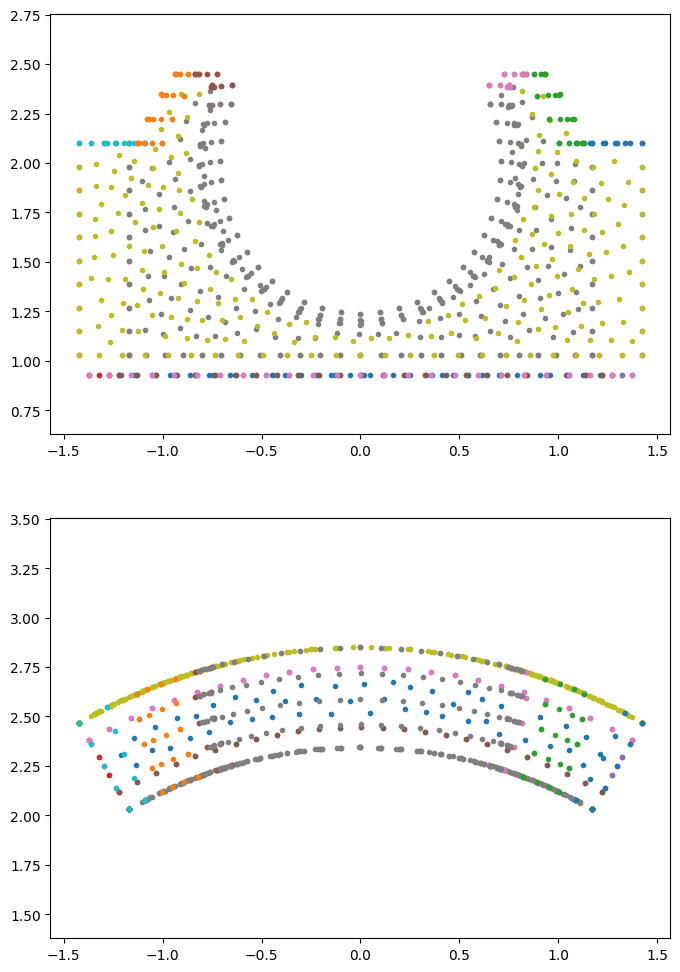

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))
plot_key = lambda key, i, style='.': ax[i].plot(key[:,0]*1e3, key[:,2-i]*1e3, style)

for i in[0,1]:
    for key in face_list:
        plot_key(eval(key), i)
    ax[i].axis('equal')


## 面同士の共通点からエッジのリストを出す

In [21]:
import pandas as pd

def common_points(point0, point1):
    df0 = pd.DataFrame(point0, columns=['x', 'y', 'z'])
    df1 = pd.DataFrame(point1, columns=['x', 'y', 'z'])
    common_points = pd.merge(df0, df1, left_on=['x', 'y', 'z'], right_on=['x', 'y', 'z'], indicator=False)
    return common_points.to_numpy()


In [22]:
curve_bottom_in = common_points(bottom, cone_in)#
curve_bottom_out = common_points(bottom, cone_out)#
curve_in_bottom = common_points(cone_in, curvature_in)#
curve_out_bottom = common_points(cone_out, curvature_out)#

curve_bottom_in.shape, curve_bottom_out.shape, curve_in_bottom.shape, curve_out_bottom.shape

((25, 3), (25, 3), (25, 3), (25, 3))

In [23]:
curve_in_top_left = common_points(curvature_in, shoulder_left)#
curve_in_top_right = common_points(curvature_in, shoulder_right)#
curve_out_top_left = common_points(curvature_out, shoulder_left)#
curve_out_top_right = common_points(curvature_out, shoulder_right)#

curve_in_top_left.shape, curve_in_top_right.shape, curve_out_top_left.shape, curve_out_top_right.shape


((3, 3), (3, 3), (3, 3), (3, 3))

In [24]:
curve_top_in_left = common_points(curvature_in, top_left)#
curve_top_in_right = common_points(curvature_in, top_right)#
curve_top_out_left = common_points(curvature_out, top_left)#
curve_top_out_right = common_points(curvature_out, top_right)#

curve_top_in_left.shape, curve_top_in_right.shape, curve_top_out_left.shape, curve_top_out_right.shape

((2, 3), (2, 3), (2, 3), (2, 3))

In [25]:
collar_middle_left = common_points(apature_left, straw_left)#
collar_middle_right = common_points(apature_right, straw_right)#

collar_middle_left.shape, collar_middle_right.shape


((5, 3), (5, 3))

In [26]:
straight_left_bottom = common_points(bottom, end_left)#
straight_right_bottom = common_points(bottom, end_right)#

straight_left_bottom.shape, straight_right_bottom.shape


((4, 3), (4, 3))

In [27]:
straight_in_left = common_points(curvature_in, end_left)#
straight_in_right = common_points(curvature_in, end_right)#
straight_out_left = common_points(curvature_out, end_left)#
straight_out_right = common_points(curvature_out, end_right)#

straight_in_left.shape, straight_in_right.shape, straight_out_left.shape, straight_out_right.shape

((10, 3), (10, 3), (10, 3), (10, 3))

In [28]:
straight_top_left = common_points(end_left, shoulder_left)#
straight_top_right = common_points(end_right, shoulder_right)#

straight_top_left.shape, straight_top_right.shape


((5, 3), (5, 3))

In [29]:
slope_bottom_left_in = common_points(cone_in, end_left)#
slope_bottom_right_in = common_points(cone_in, end_right)#
slope_bottom_left_out = common_points(cone_out, end_left)#
slope_bottom_right_out = common_points(cone_out, end_right)#

slope_bottom_left_in.shape, slope_bottom_right_in.shape, slope_bottom_left_out.shape, slope_bottom_right_out.shape

((2, 3), (2, 3), (2, 3), (2, 3))

In [30]:
slope_in_top_left = common_points(apature_left, curvature_in)#
slope_in_top_right = common_points(apature_right, curvature_in)#
slope_out_top_left = common_points(apature_left, curvature_out)#
slope_out_top_right = common_points(apature_right, curvature_out)#

slope_in_top_left.shape, slope_in_top_right.shape, slope_out_top_left.shape, slope_out_top_right.shape

((2, 3), (2, 3), (2, 3), (2, 3))

In [31]:
collar_left_out = common_points(shoulder_left, sphire_left)#
collar_right_out = common_points(shoulder_right, sphire_right)#

collar_left_out.shape, collar_right_out.shape


((5, 3), (5, 3))

In [32]:
collar_left_middle = common_points(sphire_left, top_left)#
collar_right_middle = common_points(sphire_right, top_right)#
collar_left_in = common_points(apature_left, top_left)#
collar_right_in = common_points(apature_right, top_right)#

collar_left_middle.shape, collar_right_middle.shape, collar_left_in.shape, collar_right_in.shape

((5, 3), (5, 3), (5, 3), (5, 3))

In [33]:
collar_bottom_left = common_points(sphire, straw_left)#
collar_bottom_right = common_points(sphire, straw_right)#

collar_bottom_left.shape, collar_bottom_right.shape


((5, 3), (5, 3))

In [34]:
ellipse_in_center = common_points(sphire, curvature_in)#
ellipse_in_left = common_points(curvature_in, sphire_left)#
ellipse_in_right = common_points(curvature_in, sphire_right)#
ellipse_out_center = common_points(sphire, curvature_out)#
ellipse_out_left = common_points(curvature_out, sphire_left)#
ellipse_out_right = common_points(curvature_out, sphire_right)#

ellipse_in_center.shape, ellipse_in_left.shape, ellipse_in_right.shape, ellipse_out_center.shape, ellipse_out_left.shape, ellipse_out_right.shape


((31, 3), (4, 3), (4, 3), (31, 3), (4, 3), (4, 3))

In [35]:
stripe_in_left = common_points(straw_left, curvature_in)#
stripe_in_right = common_points(straw_right, curvature_in)#
stripe_out_left = common_points(straw_left, curvature_out)#
stripe_out_right = common_points(straw_right, curvature_out)#

stripe_in_left.shape, stripe_in_right.shape, stripe_out_left.shape, stripe_out_right.shape


((2, 3), (2, 3), (2, 3), (2, 3))

In [36]:
edge_list = [
    'curve_bottom_in', 'curve_bottom_out', 'curve_in_bottom', 'curve_out_bottom', 'curve_in_top_left', 'curve_in_top_right', 'curve_out_top_left', 'curve_out_top_right', 'curve_top_in_left', 'curve_top_in_right', 'curve_top_out_left', 'curve_top_out_right',  
    'straight_left_bottom', 'straight_right_bottom', 'straight_in_left', 'straight_in_right', 'straight_out_left', 'straight_out_right', 'straight_top_left', 'straight_top_right', 
    'slope_bottom_left_in', 'slope_bottom_right_in', 'slope_bottom_left_out', 'slope_bottom_right_out', 'slope_in_top_left', 'slope_in_top_right', 'slope_out_top_left', 'slope_out_top_right', 
    'collar_left_out', 'collar_right_out', 
    'collar_left_middle', 'collar_right_middle', 'collar_left_in', 'collar_right_in', 'collar_bottom_left', 'collar_bottom_right', 'collar_middle_left', 'collar_middle_right',
    'ellipse_in_center', 'ellipse_in_left', 'ellipse_in_right', 'ellipse_out_center', 'ellipse_out_left', 'ellipse_out_right', 
    'stripe_in_left', 'stripe_in_right', 'stripe_out_left', 'stripe_out_right', 
]
if len(edge_list) != len(set(edge_list)):
    print("Duplicate elements found in the edge list.")
else:
    print("No duplicate elements found in the edge list.")

len(edge_list), sum(eval(edge).size for edge in edge_list) // 3

No duplicate elements found in the edge list.


(48, 330)

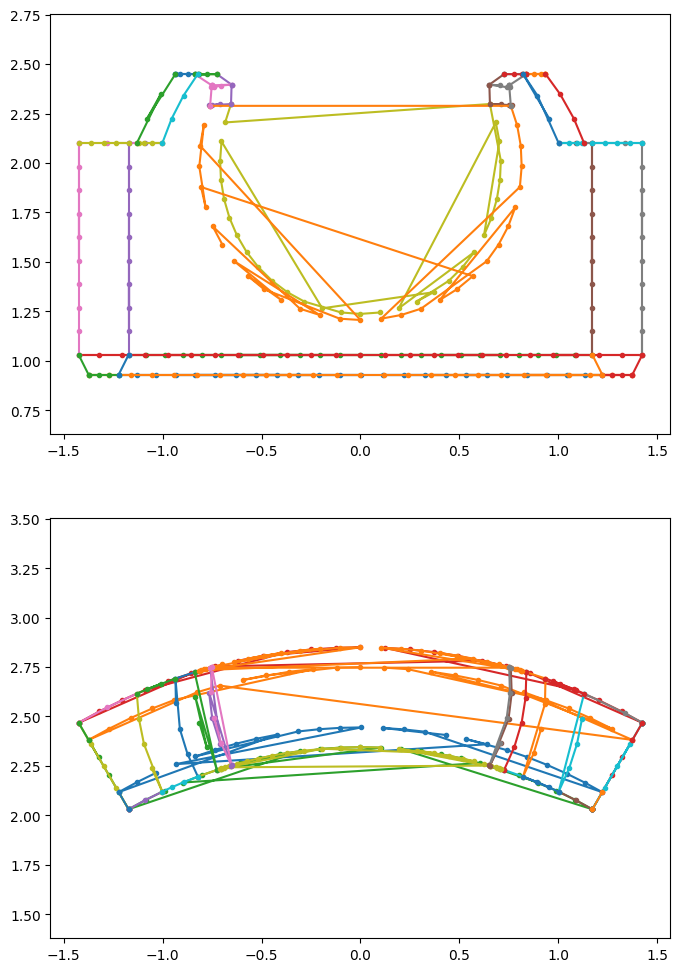

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

for i in[0,1]:
    for key in edge_list:
        plot_key(eval(key), i, style='.-')
    ax[i].axis('equal')


## エッジの並びを代数的に与える

この際，重複する点はあってもいいとする．できるなら，二重以上で定義される点は，それらが一致していることを確認する．以下の2つの作業を各エッジに対して行う．

1. エッジの座標の並びを綺麗に整列するように決める．
2. フルモデルからエッジの座標を使って対応するインデックスを取得する．
3. 


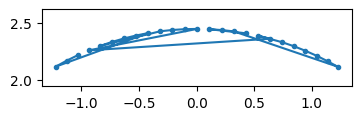

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1))
plt.plot(eval(edge_list[0])[:,0]*1e3, eval(edge_list[0])[:,1]*1e3, '.-')
plt.axis('equal')
plt.show()

In [39]:
def calculate_distances_and_find_best_axis(points):
    distances = points.max(axis=0) - points.min(axis=0)
    best_axis = np.argmax(distances)
    max_distance = distances[best_axis]
    return max_distance, best_axis

def sort_by_best_axis(points):
    _, best_axis = calculate_distances_and_find_best_axis(points)
    sorted_indices = np.argsort(points[:, best_axis])
    return points[sorted_indices]

def sort_by_azimath(points):
    azimath = np.arctan2(points[:,0] - xp[0], -points[:,2] + xp[2])
    sorted_indices = np.argsort(azimath)
    return points[sorted_indices]



In [40]:
sorted_edge_list = []

for edge in edge_list:
    edge_sorted = edge + '_sorted'

    is_ellipse = (edge.startswith('ellipse')) and (edge.endswith('center'))
    globals()[edge_sorted] = sort_by_azimath(eval(edge)) if is_ellipse else sort_by_best_axis(eval(edge))
    
    sorted_edge_list.append(edge_sorted)
    print(edge_sorted, eval(edge_sorted).shape)


curve_bottom_in_sorted (25, 3)
curve_bottom_out_sorted (25, 3)
curve_in_bottom_sorted (25, 3)
curve_out_bottom_sorted (25, 3)
curve_in_top_left_sorted (3, 3)
curve_in_top_right_sorted (3, 3)
curve_out_top_left_sorted (3, 3)
curve_out_top_right_sorted (3, 3)
curve_top_in_left_sorted (2, 3)
curve_top_in_right_sorted (2, 3)
curve_top_out_left_sorted (2, 3)
curve_top_out_right_sorted (2, 3)
straight_left_bottom_sorted (4, 3)
straight_right_bottom_sorted (4, 3)
straight_in_left_sorted (10, 3)
straight_in_right_sorted (10, 3)
straight_out_left_sorted (10, 3)
straight_out_right_sorted (10, 3)
straight_top_left_sorted (5, 3)
straight_top_right_sorted (5, 3)
slope_bottom_left_in_sorted (2, 3)
slope_bottom_right_in_sorted (2, 3)
slope_bottom_left_out_sorted (2, 3)
slope_bottom_right_out_sorted (2, 3)
slope_in_top_left_sorted (2, 3)
slope_in_top_right_sorted (2, 3)
slope_out_top_left_sorted (2, 3)
slope_out_top_right_sorted (2, 3)
collar_left_out_sorted (5, 3)
collar_right_out_sorted (5, 3)
colla

curve_top_in_right_sorted
curve_top_in_right_sorted


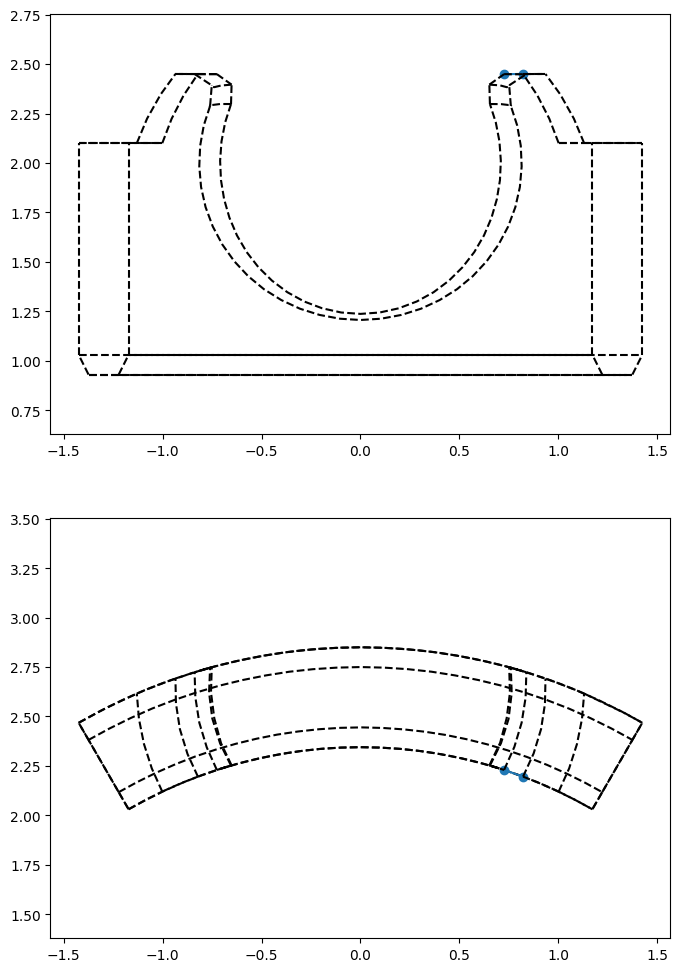

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

for i in[0,1]:
    for key in sorted_edge_list:
        plot_key(eval(key), i, style='k--')
        if ('curve_top_in_right' in key) & ('top' in key):
            print(key)
            plot_key(eval(key), i, style='o-')

    ax[i].axis('equal')


## 面からエッジを取り除く

In [42]:
def complement_points(point0, point1, ev = True):
    df0 = pd.DataFrame(point0, columns=['x', 'y', 'z'])
    for p in point1:
        df1 = pd.DataFrame(eval(p) if ev else p, columns=['x', 'y', 'z'])
        df0  = df0[~df0[['x', 'y', 'z']].apply(tuple, 1).isin(df1[['x', 'y', 'z']].apply(tuple, 1))]
    return df0.to_numpy()

complement_points_by_edge = lambda points: complement_points(points, edge_list)


In [43]:
compl_face_list = []

for face in face_list:
    name_complement = face + '_compl'
    globals()[name_complement] = complement_points_by_edge(eval(face))
    compl_face_list.append(name_complement)
    print(name_complement, eval(name_complement).shape)

len(compl_face_list), sum(eval(compl_face).shape[0] for compl_face in compl_face_list)

bottom_compl (49, 3)
top_left_compl (0, 3)
top_right_compl (0, 3)
end_left_compl (0, 3)
end_right_compl (0, 3)
cone_in_compl (0, 3)
cone_out_compl (0, 3)
curvature_in_compl (137, 3)
curvature_out_compl (170, 3)
shoulder_left_compl (3, 3)
shoulder_right_compl (3, 3)
sphire_left_compl (6, 3)
sphire_right_compl (6, 3)
straw_left_compl (0, 3)
straw_right_compl (0, 3)
apature_left_compl (0, 3)
apature_right_compl (0, 3)
sphire_compl (87, 3)


(18, 461)

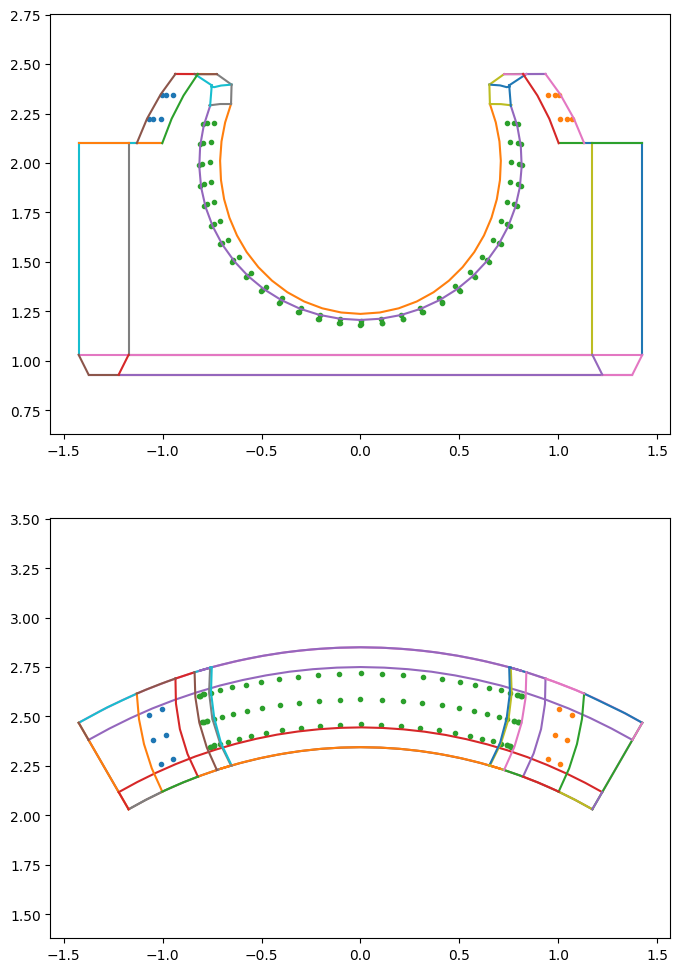

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

for i in[0,1]:
    for key in compl_face_list:
        if "sphire" in key:
            plot_key(eval(key), i, style='.')
    for key in sorted_edge_list:
        plot_key(eval(key), i, style='-')
    ax[i].axis('equal')


## 周期境界条件部分のインデックス

In [45]:
number_list = [1,4,5,8,9,]
make_file_name = lambda i: f'../data/Tetra_Cells30000/Tetra_Cells30000_{i}_0.vtu'

file_list = [make_file_name(i) for i in number_list]
file_list

['../data/Tetra_Cells30000/Tetra_Cells30000_1_0.vtu',
 '../data/Tetra_Cells30000/Tetra_Cells30000_4_0.vtu',
 '../data/Tetra_Cells30000/Tetra_Cells30000_5_0.vtu',
 '../data/Tetra_Cells30000/Tetra_Cells30000_8_0.vtu',
 '../data/Tetra_Cells30000/Tetra_Cells30000_9_0.vtu']

In [46]:
read_points = lambda f: np.array(pv.read(f).points.tolist()) 
read_points(file_list[0]).shape

(675, 3)

In [47]:
point_list = [read_points(f) for f in file_list]
point_list[0].shape

(675, 3)

In [48]:
# periodic_left = read_points(make_file_name(3))
# periodic_left.shape

In [49]:
arctan = np.arctan2(full_points[:,0], full_points[:,1])
periodic_left = full_points[(arctan > np.pi/6 * 0.999)]
periodic_right = full_points[(arctan < -np.pi/6 * 0.999)]

periodic_left.shape, periodic_right.shape
# periodic_left_ - periodic_left

((379, 3), (379, 3))

In [50]:
def exclude_common_points(point0, point1):
    new_points = []
    for point in point0:
        if not any(np.array_equal(point, p) for p in point1):
            new_points.append(point)
    return np.array(new_points)


In [51]:
def complement_points_all(point0, point_list):
    point0_copy = point0.copy()
    for point1 in point_list:
        print(point0_copy.shape, point1.shape)
        point0_copy = exclude_common_points(point0_copy, point1)
    return point0_copy

periodic_left_compl = complement_points_all(periodic_left, point_list)
periodic_right_compl = complement_points_all(periodic_right, point_list)

periodic_left_compl[0,:], periodic_right_compl[0,:]

(379, 3) (675, 3)
(352, 3) (727, 3)
(325, 3) (342, 3)
(313, 3) (345, 3)
(301, 3) (875, 3)
(379, 3) (675, 3)
(352, 3) (727, 3)
(325, 3) (342, 3)
(313, 3) (345, 3)
(301, 3) (875, 3)


(array([0.0015777 , 0.00273266, 0.0012285 ]),
 array([-0.00156852,  0.00271675,  0.00088809]))

In [52]:
compl_face_list.append('periodic_left_compl')
compl_face_list.append('periodic_right_compl')

In [53]:
# plt.figure(figsize=(6,6))
# plt.plot(periodic_left_compl[:,0]*1e3, periodic_left_compl[:,2]*1e3, '.')
# plt.axis('equal')
# plt.show()

## フルモデルからindexを抽出する

In [54]:
def get_index_in_fullmodel(full_points, points):
    df0 = pd.DataFrame(full_points, columns=['x', 'y', 'z'])
    df1 = pd.DataFrame(points, columns=['x', 'y', 'z'])
    df0['idx'] = df0.index
    df1 = df1.merge(df0, how='left', on=['x', 'y', 'z'])
    return df1['idx'].to_numpy()

get_index_in_fullmodel(full_points, eval(sorted_edge_list[0]))


array([1184, 1183, 1178, 2021, 1559, 1557, 1551, 1547, 1542, 1877, 1915,
       1917, 1921, 3678, 3677, 3675, 3896, 3122, 3123, 3140, 3144, 3149,
       3208, 3211, 3214])

In [55]:
edge_indices = []

for edge in sorted_edge_list:
    edge_full = edge + '_full'
    globals()[edge_full] = get_index_in_fullmodel(full_points, eval(edge))
    edge_indices.append(edge_full)

sum(eval(edge).shape[0] for edge in edge_indices)

330

In [56]:
face_indices = []

for face in compl_face_list:
    face_full = face + '_full'
    globals()[face_full] = get_index_in_fullmodel(full_points, eval(face))
    face_indices.append(face_full)

sum(eval(face).shape[0] for face in face_indices)


993

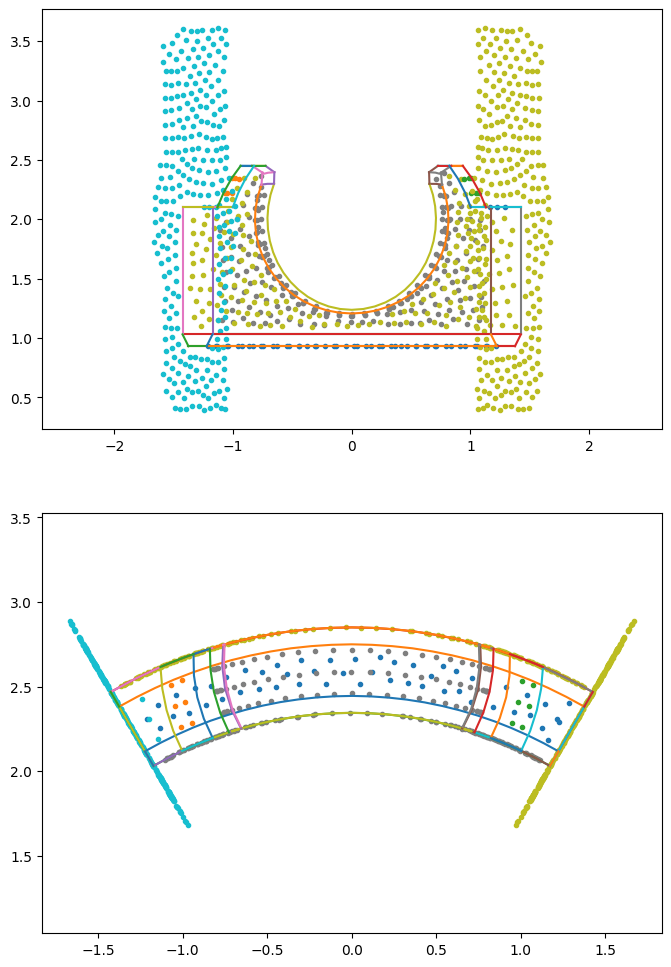

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))

for i in[0,1]:
    for key in face_indices:
        plot_key(full_points[eval(key)], i, style='.')
    for key in edge_indices:
        plot_key(full_points[eval(key)], i, style='-')
    ax[i].axis('equal')


## xmlで書き出し

In [58]:
import xml.etree.ElementTree as ET
          
root = ET.Element("root")
root.text = '\n'
root.tail = '\n'

edge_root = ET.SubElement(root, "edge")
edge_root.text = '\n'
edge_root.tail = '\n'

for edge in edge_indices:
    section = ET.SubElement(edge_root, edge[:-12])
    section.text = '\n' + ' '.join(map(str, eval(edge).tolist())) + '\n'
    section.tail = '\n'

face_root = ET.SubElement(root, "face")
face_root.text = '\n'
face_root.tail = '\n'

for face in face_indices:
    section = ET.SubElement(face_root, face[:-11])
    section.text = '\n' + ' '.join(map(str, eval(face).tolist())) + '\n'
    section.tail = '\n'

xml_string = ET.tostring(root, encoding="utf-8").decode("utf-8")

# with open("../data/face_and_edge_index_cage.xml", "w") as file:
with open("../data/face_and_edge_index.xml", "w") as file:
    file.write(xml_string)
